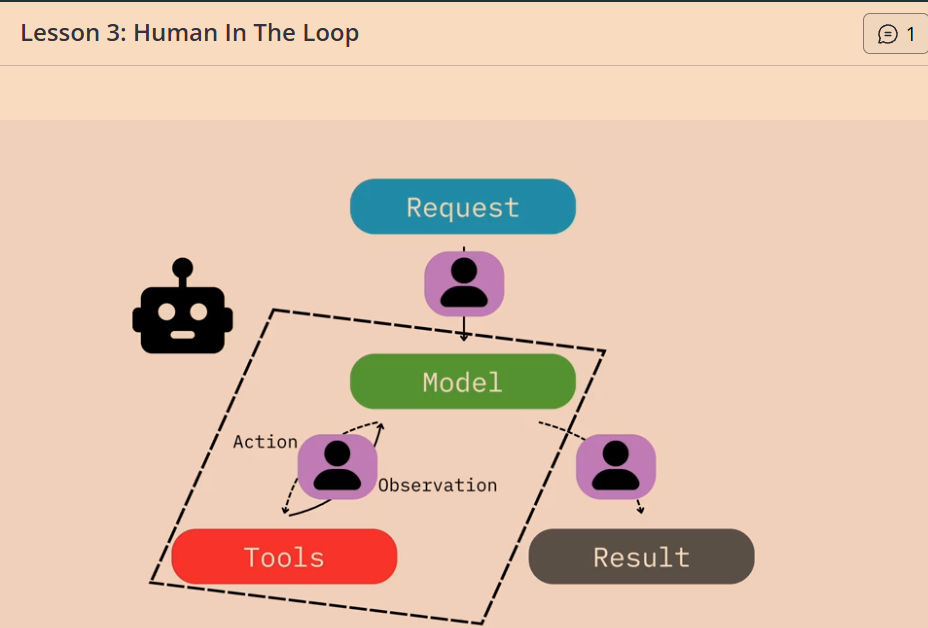
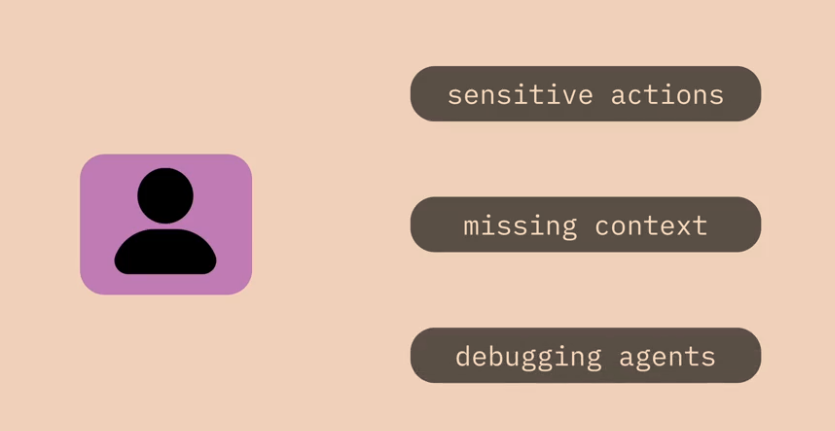

In [10]:
from dotenv import load_dotenv

load_dotenv()

True

In [11]:
from langchain.chat_models import init_chat_model
model = init_chat_model(model="meta-llama/llama-4-maverick-17b-128e-instruct",
                        model_provider="groq",
                        temperature = 0,
                        max_retries=3,
                        timeout=60,
                        max_tokens=300
                        )

In [12]:
from langchain.tools import tool, ToolRuntime

@tool
def read_email(runtime: ToolRuntime) -> str:
    """Read an email from the given address."""
    # take email from state
    return runtime.state["email"]

@tool
def send_email(body: str) -> str:
    """Send an email to the given address with the given subject and body."""
    # fake email sending
    return f"Email sent"

In [13]:
from langchain.agents import create_agent, AgentState
from langgraph.checkpoint.memory import InMemorySaver
from langchain.agents.middleware import HumanInTheLoopMiddleware

class EmailState(AgentState):
    email: str

agent = create_agent(
    model=model,
    tools=[read_email, send_email],
    state_schema=EmailState,
    checkpointer=InMemorySaver(),
    middleware=[
        HumanInTheLoopMiddleware( # human approval for sending emails prebuilt middleware in langchain
            interrupt_on={
                "read_email": False,
                "send_email": True, # automatic approval for reading email, human approval for sending email
            },
            description_prefix="Tool execution requires approval",
        ),
    ],
)

In [14]:
from langchain.messages import HumanMessage

config = {"configurable": {"thread_id": "1"}}

response = agent.invoke(
    {
        "messages": [HumanMessage(content="Please read my email and send a response.")],
        "email": "Hi Farhan, I'm going to be late for our meeting tomorrow. Can we reschedule? Best, John."
    }, # type: ignore
    config=config # type: ignore
)

In [15]:
from pprint import pprint

pprint(response)

{'__interrupt__': [Interrupt(value={'action_requests': [{'args': {'body': 'Your '
                                                                          'response '
                                                                          'here'},
                                                         'description': 'Tool '
                                                                        'execution '
                                                                        'requires '
                                                                        'approval\n'
                                                                        '\n'
                                                                        'Tool: '
                                                                        'send_email\n'
                                                                        'Args: '
                                                                        "{'body': "
     

In [16]:
print(response['__interrupt__'])

[Interrupt(value={'action_requests': [{'name': 'send_email', 'args': {'body': 'Your response here'}, 'description': "Tool execution requires approval\n\nTool: send_email\nArgs: {'body': 'Your response here'}"}], 'review_configs': [{'action_name': 'send_email', 'allowed_decisions': ['approve', 'edit', 'reject']}]}, id='37f3456874cb5d55ce2a9ca59964b1e1')]


In [17]:
# Access just the 'body' argument from the tool call
print(response['__interrupt__'][0].value['action_requests'][0]['args']['body'])

Your response here


## Approve

In [18]:
from langgraph.types import Command

response = agent.invoke(
    Command( 
        resume={"decisions": [{"type": "approve"}]}
    ), 
    config=config # Same thread ID to resume the paused conversation # type: ignore
)

pprint(response)

{'email': "Hi Farhan, I'm going to be late for our meeting tomorrow. Can we "
          'reschedule? Best, John.',
 'messages': [HumanMessage(content='Please read my email and send a response.', additional_kwargs={}, response_metadata={}, id='eba8d5a9-4fc1-4c33-ad79-adca8a4fc783'),
              AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 's6faz1wdv', 'function': {'arguments': '{}', 'name': 'read_email'}, 'type': 'function'}, {'id': 'z4r760792', 'function': {'arguments': '{"body":"Your response here"}', 'name': 'send_email'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 48, 'prompt_tokens': 747, 'total_tokens': 795, 'completion_time': 0.058900136, 'completion_tokens_details': None, 'prompt_time': 0.015071764, 'prompt_tokens_details': None, 'queue_time': 0.054311136, 'total_time': 0.0739719}, 'model_name': 'meta-llama/llama-4-maverick-17b-128e-instruct', 'system_fingerprint': 'fp_d2c1f7e199', 'service_tier': 'on_demand', 'finish_reaso

## Reject

In [19]:
response = agent.invoke(
    Command(        
        resume={
            "decisions": [
                {
                    "type": "reject",
                    # An explanation of why the request was rejected
                    "message": "No please sign off - Your merciful leader, Seán."
                }
            ]
        }
    ), 
    config=config # Same thread ID to resume the paused conversation # type: ignore
    )   

pprint(response)

{'email': "Hi Farhan, I'm going to be late for our meeting tomorrow. Can we "
          'reschedule? Best, John.',
 'messages': [HumanMessage(content='Please read my email and send a response.', additional_kwargs={}, response_metadata={}, id='eba8d5a9-4fc1-4c33-ad79-adca8a4fc783'),
              AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 's6faz1wdv', 'function': {'arguments': '{}', 'name': 'read_email'}, 'type': 'function'}, {'id': 'z4r760792', 'function': {'arguments': '{"body":"Your response here"}', 'name': 'send_email'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 48, 'prompt_tokens': 747, 'total_tokens': 795, 'completion_time': 0.058900136, 'completion_tokens_details': None, 'prompt_time': 0.015071764, 'prompt_tokens_details': None, 'queue_time': 0.054311136, 'total_time': 0.0739719}, 'model_name': 'meta-llama/llama-4-maverick-17b-128e-instruct', 'system_fingerprint': 'fp_d2c1f7e199', 'service_tier': 'on_demand', 'finish_reaso

In [20]:
print(response['__interrupt__'][0].value['action_requests'][0]['args']['body'])

KeyError: '__interrupt__'

## Edit

In [21]:
response = agent.invoke(
    Command(        
        resume={
            "decisions": [
                {
                    "type": "edit",
                    # Edited action with tool name and args
                    "edited_action": {
                        # Tool name to call.
                        # Will usually be the same as the original action.
                        "name": "send_email",
                        # Arguments to pass to the tool.
                        "args": {"body": "This is the last straw, you're fired!"},
                    }
                }
            ]
        }
    ), 
    config=config # Same thread ID to resume the paused conversation
    )   

pprint(response)

{'email': "Hi Farhan, I'm going to be late for our meeting tomorrow. Can we "
          'reschedule? Best, John.',
 'messages': [HumanMessage(content='Please read my email and send a response.', additional_kwargs={}, response_metadata={}, id='eba8d5a9-4fc1-4c33-ad79-adca8a4fc783'),
              AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 's6faz1wdv', 'function': {'arguments': '{}', 'name': 'read_email'}, 'type': 'function'}, {'id': 'z4r760792', 'function': {'arguments': '{"body":"Your response here"}', 'name': 'send_email'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 48, 'prompt_tokens': 747, 'total_tokens': 795, 'completion_time': 0.058900136, 'completion_tokens_details': None, 'prompt_time': 0.015071764, 'prompt_tokens_details': None, 'queue_time': 0.054311136, 'total_time': 0.0739719}, 'model_name': 'meta-llama/llama-4-maverick-17b-128e-instruct', 'system_fingerprint': 'fp_d2c1f7e199', 'service_tier': 'on_demand', 'finish_reaso